### 4.3.3. 가짜 이미지 생성

얼굴 이미지 데이터셋 주소

https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

In [1]:
using Flux
import Zygote, Optimisers, MLUtils
using Formatting: format
import Images
#import ImageView # 주피터에선 바로 이미지 볼 수 있으므로 필요없음
import Statistics
using Random: MersenneTwister

사용자 정의 데이터셋

In [2]:
struct ImageSet
    path::String
    files::Vector{String}
    ImageSet(path::String) = begin
        files = joinpath.(path, readdir(path))
        files = filter(p -> endswith(p, ".jpg"), files)
        return new(path, files)
    end
end

In [3]:
function Base.getindex(imgs::ImageSet, i::Int64)
    img = Images.load(imgs.files[i])    # 218 x 178
    img = @view img[21:end-20, :]       # 178 x 178 (center crop)
    img = Images.imresize(img, 64, 64)  # 64 x 64
    img = Images.channelview(img)       # 3 x 64 x 64
    img = permutedims(img, (3,2,1))     # 64 x 64 x 3
    img = (img .- 0.5f0) ./ 0.5f0       # nomalise to [-1,1]
    return img
end
Base.length(imgs::ImageSet) = length(imgs.files)

In [4]:
images = ImageSet("/home/tyfun/Downloads/img_align_celeba")
rng = MersenneTwister(1)
loader = MLUtils.DataLoader(images, batchsize=128, collate=true, rng=rng, shuffle=true)

1583-element DataLoader(::ImageSet, shuffle=true, batchsize=128, collate=Val{true}(), rng=MersenneTwister(1))
  with first element:
  64×64×3×128 Array{Float32, 4}

In [5]:
function show_imgs(batch, ncol)
    data = MLUtils.unbatch(batch)
    imgs = map(data) do arr
        arr = arr .* 0.5f0 .+ 0.5f0
        arr = permutedims(arr, (3,2,1))
        Images.colorview(Images.RGB, arr)
    end
    rows = MLUtils.chunk(imgs; size = ncol)
    imgs = map(r -> hcat(r...), rows)
    imgs = vcat(imgs...)
    #ImageView.imshow(imgs) # comment for inline display on Jupyter
end

show_imgs (generic function with 1 method)

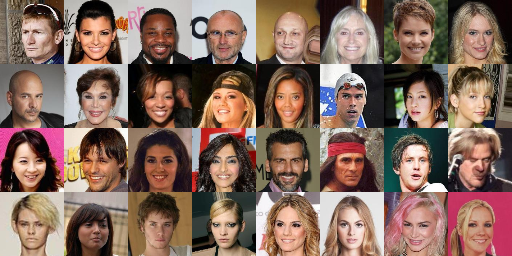

In [6]:
show_imgs(first(loader)[:,:,:,1:32], 8)

생성자와 판별자

In [7]:
dcgan_init(rng) = (shape...) -> randn(rng, Float32, shape) * 0.02f0

dcgan_init (generic function with 1 method)

In [8]:
function Generator(rng, nz = 100, ngf = 64, nc = 3)
    Chain(
        ConvTranspose((4, 4), nz => ngf * 8; # 4 x 4
            stride = 1, pad = 0, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 8, relu),

        ConvTranspose((4, 4), ngf * 8 => ngf * 4; # 8 x 8
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 4, relu),

        ConvTranspose((4, 4), ngf * 4 => ngf * 2; # 16 x 16
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 2, relu),

        ConvTranspose((4, 4), ngf * 2 => ngf;  # 32 x 32
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf, relu),

        ConvTranspose((4, 4), ngf => nc, tanh; # 64 x 64
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
    )
end

Generator (generic function with 4 methods)

In [9]:
function Discriminator(rng, nc = 3, ndf = 64)
    Chain(
        Conv((4, 4), nc => ndf;         # 32 x 32
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        x -> leakyrelu.(x, 0.2f0),

        Conv((4, 4), ndf => ndf * 2;    # 16 x 16
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 2),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 2 => ndf * 4; # 8 x 8
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 4),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 4 => ndf * 8; # 4 x 4
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 8),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 8 => 1;
            stride = 1, pad = 0, init = dcgan_init(rng), bias=false),
    )
end

Discriminator (generic function with 3 methods)

훈련

In [10]:
function train_gan(loader, epochs; rng, nz = 100, ngf = 64, nc = 3, ndf = 64)
    netG = Generator(rng, nz, ngf, nc) |> gpu
    netD = Discriminator(rng, nc, ndf) |> gpu

    opt_pars = (0.0002f0, (0.5f0, 0.999f0))
    optG = Optimisers.setup(Optimisers.Adam(opt_pars...), netG);
    optD = Optimisers.setup(Optimisers.Adam(opt_pars...), netD);

    loss_fn = Flux.Losses.logitbinarycrossentropy

    for epoch in 1:epochs
        for (i, real) in enumerate(loader)
            D_x, D_G_z1, D_G_z2 = 0.f0, 0.f0, 0.f0
            show_stat = i % 200 == 0

            real = real |> gpu
            b_size = size(real)[end]
            
            label_real = fill(1.f0, b_size) |> gpu
            label_fake = fill(0.f0, b_size) |> gpu

            noise = randn(Float32, 1, 1, nz, b_size) |> gpu
            fake = netG(noise)

            # Update D network
            errD, errD_grad = Zygote.withgradient(netD) do m
                loss_real = loss_fn(vec(m(real)), label_real)
                loss_fake = loss_fn(vec(m(fake)), label_fake)
                loss_real + loss_fake
            end
            optD, netD = Optimisers.update(optD, netD, errD_grad[1])
        
            !show_stat || (D_x = Statistics.mean(netD(real)))
            !show_stat || (D_G_z1 = Statistics.mean(netD(fake)))

            # Update G network
            errG, errG_grad = Zygote.withgradient(netG) do m
                loss_fn(vec(netD(m(noise))), label_real)
            end
            optG, netG = Optimisers.update(optG, netG, errG_grad[1]);
            
            !show_stat || (D_G_z2 = Statistics.mean(netD(netG(noise))))

            # Output training stats
            if show_stat
                header = "[$epoch / $epochs] [$i / $(length(loader))]"
                loss = format("LossD: {:.4f}\tLossG: {:.4f}", errD, errG)
                probs = format("D(x): {:.4f}\tD(G(z)): {:.4f} / {:.4f}", 
                    σ(D_x), σ(D_G_z1), σ(D_G_z2))
                println("$header\t$loss\t$probs")
            end
        end
    end
    netG, netD
end

train_gan (generic function with 1 method)

In [11]:
nz = 100
rng = MersenneTwister(1)
@time netG, _ = train_gan(loader, 20; rng = rng, nz = nz);

[1 / 20] [200 / 1583]	LossD: 1.1706	LossG: 3.0514	D(x): 0.9309	D(G(z)): 0.1524 / 0.4108


[1 / 20] [400 / 1583]	LossD: 0.8033	LossG: 1.6937	D(x): 0.9053	D(G(z)): 0.2219 / 0.4820


[1 / 20] [600 / 1583]	LossD: 0.7993	LossG: 1.7223	D(x): 0.8745	D(G(z)): 0.1815 / 0.4700


[1 / 20] [800 / 1583]	LossD: 0.3220	LossG: 2.2501	D(x): 0.8385	D(G(z)): 0.0518 / 0.2307


[1 / 20] [1000 / 1583]	LossD: 0.0785	LossG: 0.5070	D(x): 0.9219	D(G(z)): 0.2003 / 0.4560


[1 / 20] [1200 / 1583]	LossD: 0.2482	LossG: 1.2006	D(x): 0.8690	D(G(z)): 0.0336 / 0.1804


[1 / 20] [1400 / 1583]	LossD: 0.3680	LossG: 1.6914	D(x): 0.8168	D(G(z)): 0.0986 / 0.2338


[2 / 20] [200 / 1583]	LossD: 1.2164	LossG: 3.7440	D(x): 0.9439	D(G(z)): 0.0140 / 0.1645


[2 / 20] [400 / 1583]	LossD: 0.2165	LossG: 0.2396	D(x): 0.8590	D(G(z)): 0.3813 / 0.5195


[2 / 20] [600 / 1583]	LossD: 0.3171	LossG: 0.9678	D(x): 0.9212	D(G(z)): 0.0818 / 0.2651


[2 / 20] [800 / 1583]	LossD: 0.1455	LossG: 0.7360	D(x): 0.9844	D(G(z)): 0.0936 / 0.3548


[2 / 20] [1000 / 1583]	LossD: 0.8107	LossG: 4.6030	D(x): 0.8769	D(G(z)): 0.0248 / 0.3289


[2 / 20] [1200 / 1583]	LossD: 0.1159	LossG: 0.0291	D(x): 0.9403	D(G(z)): 0.2548 / 0.4305


[2 / 20] [1400 / 1583]	LossD: 0.0776	LossG: 0.2777	D(x): 0.8741	D(G(z)): 0.5297 / 0.6513


[3 / 20] [200 / 1583]	LossD: 0.2523	LossG: 1.6068	D(x): 0.8528	D(G(z)): 0.0771 / 0.2854


[3 / 20] [400 / 1583]	LossD: 1.7865	LossG: 2.4322	D(x): 0.9069	D(G(z)): 0.0768 / 0.4188


[3 / 20] [600 / 1583]	LossD: 0.1559	LossG: 0.7998	D(x): 0.9097	D(G(z)): 0.1215 / 0.2193


[3 / 20] [800 / 1583]	LossD: 0.2744	LossG: 0.6229	D(x): 0.9033	D(G(z)): 0.1195 / 0.4631


[3 / 20] [1000 / 1583]	LossD: 0.0597	LossG: 0.0829	D(x): 0.8035	D(G(z)): 0.3874 / 0.5031


[3 / 20] [1200 / 1583]	LossD: 0.7834	LossG: 1.6329	D(x): 0.8556	D(G(z)): 0.2005 / 0.5379


[3 / 20] [1400 / 1583]	LossD: 0.2571	LossG: 0.3408	D(x): 0.9118	D(G(z)): 0.2154 / 0.3640


[4 / 20] [200 / 1583]	LossD: 0.0609	LossG: 0.1648	D(x): 0.6881	D(G(z)): 0.3503 / 0.4972


[4 / 20] [400 / 1583]	LossD: 0.6786	LossG: 4.8503	D(x): 0.5026	D(G(z)): 0.0846 / 0.1757


[4 / 20] [600 / 1583]	LossD: 0.2429	LossG: 0.8309	D(x): 0.8956	D(G(z)): 0.1792 / 0.3029


[4 / 20] [800 / 1583]	LossD: 0.4084	LossG: 0.7654	D(x): 0.7896	D(G(z)): 0.1349 / 0.2375


[4 / 20] [1000 / 1583]	LossD: 0.2778	LossG: 0.4262	D(x): 0.8064	D(G(z)): 0.1524 / 0.2368


[4 / 20] [1200 / 1583]	LossD: 0.0627	LossG: 0.2520	D(x): 0.6205	D(G(z)): 0.3267 / 0.4490


[4 / 20] [1400 / 1583]	LossD: 0.0609	LossG: 0.0641	D(x): 0.7630	D(G(z)): 0.4095 / 0.5358


[5 / 20] [200 / 1583]	LossD: 0.2503	LossG: 0.0478	D(x): 0.8879	D(G(z)): 0.3990 / 0.5299


[5 / 20] [400 / 1583]	LossD: 0.4273	LossG: 0.3622	D(x): 0.7977	D(G(z)): 0.2104 / 0.3236


[5 / 20] [600 / 1583]	LossD: 0.8201	LossG: 1.6365	D(x): 0.9302	D(G(z)): 0.4081 / 0.6405


[5 / 20] [800 / 1583]	LossD: 2.9961	LossG: 1.0749	D(x): 0.8774	D(G(z)): 0.3968 / 0.5837


[5 / 20] [1000 / 1583]	LossD: 0.6920	LossG: 2.9390	D(x): 0.6440	D(G(z)): 0.1153 / 0.2740


[5 / 20] [1200 / 1583]	LossD: 1.4156	LossG: 0.5631	D(x): 0.9129	D(G(z)): 0.5047 / 0.6442


[5 / 20] [1400 / 1583]	LossD: 0.3626	LossG: 0.3292	D(x): 0.7230	D(G(z)): 0.2933 / 0.4052


[6 / 20] [200 / 1583]	LossD: 0.5028	LossG: 0.3794	D(x): 0.8482	D(G(z)): 0.2512 / 0.3564


[6 / 20] [400 / 1583]	LossD: 0.2152	LossG: 0.1790	D(x): 0.7632	D(G(z)): 0.3934 / 0.4886


[6 / 20] [600 / 1583]	LossD: 0.1629	LossG: 0.5911	D(x): 0.7419	D(G(z)): 0.2350 / 0.3406


[6 / 20] [800 / 1583]	LossD: 0.6540	LossG: 2.6780	D(x): 0.6336	D(G(z)): 0.2393 / 0.4242


[6 / 20] [1000 / 1583]	LossD: 0.2794	LossG: 0.1641	D(x): 0.7964	D(G(z)): 0.3867 / 0.4817


[6 / 20] [1200 / 1583]	LossD: 0.1385	LossG: 0.0622	D(x): 0.7829	D(G(z)): 0.6620 / 0.7553


[6 / 20] [1400 / 1583]	LossD: 0.4898	LossG: 0.1833	D(x): 0.8234	D(G(z)): 0.5342 / 0.6245


[7 / 20] [200 / 1583]	LossD: 0.3122	LossG: 0.1190	D(x): 0.7376	D(G(z)): 0.3754 / 0.5072


[7 / 20] [400 / 1583]	LossD: 0.9732	LossG: 1.4384	D(x): 0.6776	D(G(z)): 0.2595 / 0.3785


[7 / 20] [600 / 1583]	LossD: 0.2231	LossG: 0.2592	D(x): 0.7228	D(G(z)): 0.3792 / 0.4783


[7 / 20] [800 / 1583]	LossD: 0.1877	LossG: 0.0660	D(x): 0.8170	D(G(z)): 0.5669 / 0.6603


[7 / 20] [1000 / 1583]	LossD: 0.4182	LossG: 1.1328	D(x): 0.6424	D(G(z)): 0.2760 / 0.4136


[7 / 20] [1200 / 1583]	LossD: 0.2310	LossG: 0.2310	D(x): 0.8398	D(G(z)): 0.4151 / 0.5060


[7 / 20] [1400 / 1583]	LossD: 0.3787	LossG: 0.5742	D(x): 0.6582	D(G(z)): 0.2475 / 0.3605


[8 / 20] [200 / 1583]	LossD: 0.1671	LossG: 0.1412	D(x): 0.6805	D(G(z)): 0.4639 / 0.5305


[8 / 20] [400 / 1583]	LossD: 0.2170	LossG: 0.0879	D(x): 0.7148	D(G(z)): 0.3996 / 0.4991


[8 / 20] [600 / 1583]	LossD: 2.2608	LossG: 0.8891	D(x): 0.6821	D(G(z)): 0.2417 / 0.3050


[8 / 20] [800 / 1583]	LossD: 0.0838	LossG: 0.0959	D(x): 0.8482	D(G(z)): 0.5636 / 0.6655


[8 / 20] [1000 / 1583]	LossD: 0.1468	LossG: 0.1887	D(x): 0.7615	D(G(z)): 0.3416 / 0.4432


[8 / 20] [1200 / 1583]	LossD: 1.5602	LossG: 1.3605	D(x): 0.8710	D(G(z)): 0.5137 / 0.6301


[8 / 20] [1400 / 1583]	LossD: 0.7359	LossG: 0.1848	D(x): 0.7187	D(G(z)): 0.5170 / 0.6361


[9 / 20] [200 / 1583]	LossD: 0.6869	LossG: 1.2395	D(x): 0.7821	D(G(z)): 0.2669 / 0.4118


[9 / 20] [400 / 1583]	LossD: 1.6421	LossG: 2.0100	D(x): 0.8912	D(G(z)): 0.8404 / 0.8487


[9 / 20] [600 / 1583]	LossD: 0.4730	LossG: 2.3641	D(x): 0.5521	D(G(z)): 0.2776 / 0.3531


[9 / 20] [800 / 1583]	LossD: 1.2577	LossG: 1.6530	D(x): 0.6489	D(G(z)): 0.2320 / 0.3347


[9 / 20] [1000 / 1583]	LossD: 0.6934	LossG: 1.6329	D(x): 0.7581	D(G(z)): 0.2894 / 0.4100


[9 / 20] [1200 / 1583]	LossD: 1.2265	LossG: 0.6808	D(x): 0.5744	D(G(z)): 0.3011 / 0.4228


[9 / 20] [1400 / 1583]	LossD: 0.6458	LossG: 0.4262	D(x): 0.8373	D(G(z)): 0.5977 / 0.6722


[10 / 20] [200 / 1583]	LossD: 1.0513	LossG: 1.6135	D(x): 0.5779	D(G(z)): 0.2910 / 0.3995


[10 / 20] [400 / 1583]	LossD: 1.0652	LossG: 1.0829	D(x): 0.7211	D(G(z)): 0.4226 / 0.4904


[10 / 20] [600 / 1583]	LossD: 0.5982	LossG: 1.8115	D(x): 0.6193	D(G(z)): 0.2998 / 0.3850


[10 / 20] [800 / 1583]	LossD: 0.5309	LossG: 0.1476	D(x): 0.4451	D(G(z)): 0.2831 / 0.3762


[10 / 20] [1000 / 1583]	LossD: 0.7282	LossG: 0.1863	D(x): 0.5697	D(G(z)): 0.4338 / 0.5242


[10 / 20] [1200 / 1583]	LossD: 1.0817	LossG: 0.2253	D(x): 0.8399	D(G(z)): 0.6809 / 0.7398


[10 / 20] [1400 / 1583]	LossD: 0.7310	LossG: 0.3610	D(x): 0.8073	D(G(z)): 0.5298 / 0.5919


[11 / 20] [200 / 1583]	LossD: 0.9748	LossG: 0.8524	D(x): 0.5774	D(G(z)): 0.3717 / 0.4627


[11 / 20] [400 / 1583]	LossD: 0.9375	LossG: 0.4032	D(x): 0.6560	D(G(z)): 0.4963 / 0.5757


[11 / 20] [600 / 1583]	LossD: 0.4281	LossG: 0.2241	D(x): 0.7577	D(G(z)): 0.5710 / 0.6493


[11 / 20] [800 / 1583]	LossD: 0.5155	LossG: 0.2750	D(x): 0.6769	D(G(z)): 0.4277 / 0.4973


[11 / 20] [1000 / 1583]	LossD: 1.0271	LossG: 1.1361	D(x): 0.5606	D(G(z)): 0.3263 / 0.4208


[11 / 20] [1200 / 1583]	LossD: 0.9210	LossG: 1.5435	D(x): 0.4568	D(G(z)): 0.3021 / 0.3835


[11 / 20] [1400 / 1583]	LossD: 0.8369	LossG: 0.9143	D(x): 0.6664	D(G(z)): 0.3986 / 0.4652


[12 / 20] [200 / 1583]	LossD: 0.9174	LossG: 0.9180	D(x): 0.6128	D(G(z)): 0.4472 / 0.5137


[12 / 20] [400 / 1583]	LossD: 0.6958	LossG: 0.3270	D(x): 0.7007	D(G(z)): 0.5620 / 0.6098


[12 / 20] [600 / 1583]	LossD: 0.4088	LossG: 2.7666	D(x): 0.7178	D(G(z)): 0.1618 / 0.2705


[12 / 20] [800 / 1583]	LossD: 0.8824	LossG: 1.0038	D(x): 0.6324	D(G(z)): 0.3473 / 0.4421


[12 / 20] [1000 / 1583]	LossD: 0.8382	LossG: 1.6875	D(x): 0.7067	D(G(z)): 0.4252 / 0.4740


[12 / 20] [1200 / 1583]	LossD: 0.9263	LossG: 1.5685	D(x): 0.5973	D(G(z)): 0.3095 / 0.3967


[12 / 20] [1400 / 1583]	LossD: 0.5769	LossG: 0.4886	D(x): 0.5393	D(G(z)): 0.3355 / 0.3942


[13 / 20] [200 / 1583]	LossD: 0.3222	LossG: 2.3990	D(x): 0.5333	D(G(z)): 0.2780 / 0.2951


[13 / 20] [400 / 1583]	LossD: 0.6054	LossG: 0.3260	D(x): 0.7346	D(G(z)): 0.6209 / 0.6704


[13 / 20] [600 / 1583]	LossD: 1.7130	LossG: 0.5581	D(x): 0.8589	D(G(z)): 0.7135 / 0.7416


[13 / 20] [800 / 1583]	LossD: 0.8152	LossG: 0.7078	D(x): 0.5688	D(G(z)): 0.3802 / 0.4496


[13 / 20] [1000 / 1583]	LossD: 1.2226	LossG: 1.0458	D(x): 0.6012	D(G(z)): 0.4230 / 0.4804


[13 / 20] [1200 / 1583]	LossD: 1.3188	LossG: 1.1028	D(x): 0.4936	D(G(z)): 0.2066 / 0.2556


[13 / 20] [1400 / 1583]	LossD: 0.7352	LossG: 0.5573	D(x): 0.5769	D(G(z)): 0.4909 / 0.5567


[14 / 20] [200 / 1583]	LossD: 1.5104	LossG: 0.9494	D(x): 0.4179	D(G(z)): 0.3439 / 0.4127


[14 / 20] [400 / 1583]	LossD: 1.0874	LossG: 1.0088	D(x): 0.5504	D(G(z)): 0.3933 / 0.4473


[14 / 20] [600 / 1583]	LossD: 1.3343	LossG: 0.9674	D(x): 0.5687	D(G(z)): 0.4114 / 0.4583


[14 / 20] [800 / 1583]	LossD: 0.7943	LossG: 0.7377	D(x): 0.4314	D(G(z)): 0.3295 / 0.3703


[14 / 20] [1000 / 1583]	LossD: 1.5457	LossG: 1.0051	D(x): 0.4528	D(G(z)): 0.4009 / 0.4451


[14 / 20] [1200 / 1583]	LossD: 1.6603	LossG: 0.7423	D(x): 0.5425	D(G(z)): 0.4297 / 0.4836


[14 / 20] [1400 / 1583]	LossD: 1.3379	LossG: 1.3434	D(x): 0.4897	D(G(z)): 0.4054 / 0.4505


[15 / 20] [200 / 1583]	LossD: 1.2092	LossG: 0.4420	D(x): 0.6422	D(G(z)): 0.5015 / 0.5633


[15 / 20] [400 / 1583]	LossD: 0.8866	LossG: 0.3929	D(x): 0.6230	D(G(z)): 0.5128 / 0.5560


[15 / 20] [600 / 1583]	LossD: 1.3013	LossG: 0.4277	D(x): 0.5602	D(G(z)): 0.4474 / 0.5024


[15 / 20] [800 / 1583]	LossD: 1.3460	LossG: 1.6111	D(x): 0.3810	D(G(z)): 0.3221 / 0.3595


[15 / 20] [1000 / 1583]	LossD: 1.2535	LossG: 0.9029	D(x): 0.5945	D(G(z)): 0.5265 / 0.5527


[15 / 20] [1200 / 1583]	LossD: 1.2756	LossG: 1.2180	D(x): 0.4706	D(G(z)): 0.4316 / 0.4846


[15 / 20] [1400 / 1583]	LossD: 1.3208	LossG: 0.8805	D(x): 0.5282	D(G(z)): 0.4768 / 0.5200


[16 / 20] [200 / 1583]	LossD: 0.0620	LossG: 0.2436	D(x): 0.2017	D(G(z)): 0.4833 / 0.5395


[16 / 20] [400 / 1583]	LossD: 1.1087	LossG: 0.7775	D(x): 0.5652	D(G(z)): 0.2871 / 0.3917


[16 / 20] [600 / 1583]	LossD: 0.7057	LossG: 0.1621	D(x): 0.7207	D(G(z)): 0.6194 / 0.6659


[16 / 20] [800 / 1583]	LossD: 1.9953	LossG: 0.4769	D(x): 0.7807	D(G(z)): 0.5976 / 0.6529


[16 / 20] [1000 / 1583]	LossD: 1.2612	LossG: 0.9237	D(x): 0.5417	D(G(z)): 0.3988 / 0.4537


[16 / 20] [1200 / 1583]	LossD: 1.1762	LossG: 0.9225	D(x): 0.5700	D(G(z)): 0.4220 / 0.4917


[16 / 20] [1400 / 1583]	LossD: 0.6709	LossG: 0.9261	D(x): 0.4275	D(G(z)): 0.3240 / 0.3844


[17 / 20] [200 / 1583]	LossD: 0.6295	LossG: 0.4932	D(x): 0.5660	D(G(z)): 0.3899 / 0.4880


[17 / 20] [400 / 1583]	LossD: 0.1064	LossG: 0.1895	D(x): 0.0072	D(G(z)): 0.4115 / 0.4744


[17 / 20] [600 / 1583]	LossD: 0.8354	LossG: 0.6412	D(x): 0.6552	D(G(z)): 0.4199 / 0.4809


[17 / 20] [800 / 1583]	LossD: 1.0075	LossG: 0.3433	D(x): 0.7334	D(G(z)): 0.4745 / 0.5601


[17 / 20] [1000 / 1583]	LossD: 0.8243	LossG: 0.1113	D(x): 0.5988	D(G(z)): 0.4665 / 0.5721


[17 / 20] [1200 / 1583]	LossD: 0.5506	LossG: 0.0714	D(x): 0.5680	D(G(z)): 0.5449 / 0.6253


[17 / 20] [1400 / 1583]	LossD: 1.2477	LossG: 0.4699	D(x): 0.6827	D(G(z)): 0.5109 / 0.5694


[18 / 20] [200 / 1583]	LossD: 1.5126	LossG: 0.7799	D(x): 0.5728	D(G(z)): 0.4355 / 0.4905


[18 / 20] [400 / 1583]	LossD: 1.7111	LossG: 1.2286	D(x): 0.4488	D(G(z)): 0.3483 / 0.3930


[18 / 20] [600 / 1583]	LossD: 1.0651	LossG: 0.4022	D(x): 0.6929	D(G(z)): 0.5681 / 0.6015


[18 / 20] [800 / 1583]	LossD: 0.4681	LossG: 0.4374	D(x): 0.4036	D(G(z)): 0.3080 / 0.3618


[18 / 20] [1000 / 1583]	LossD: 1.4044	LossG: 0.8768	D(x): 0.5496	D(G(z)): 0.4148 / 0.4687


[18 / 20] [1200 / 1583]	LossD: 1.2700	LossG: 0.9683	D(x): 0.5006	D(G(z)): 0.3856 / 0.4428


[18 / 20] [1400 / 1583]	LossD: 1.5767	LossG: 0.7605	D(x): 0.4975	D(G(z)): 0.4221 / 0.4687


[19 / 20] [200 / 1583]	LossD: 0.7333	LossG: 0.7937	D(x): 0.4613	D(G(z)): 0.4032 / 0.4717


[19 / 20] [400 / 1583]	LossD: 1.2652	LossG: 1.0883	D(x): 0.5430	D(G(z)): 0.3956 / 0.4548


[19 / 20] [600 / 1583]	LossD: 1.3525	LossG: 1.1972	D(x): 0.4720	D(G(z)): 0.3429 / 0.3926


[19 / 20] [800 / 1583]	LossD: 2.0925	LossG: 0.4479	D(x): 0.5393	D(G(z)): 0.4746 / 0.5283


[19 / 20] [1000 / 1583]	LossD: 1.5606	LossG: 0.9175	D(x): 0.5725	D(G(z)): 0.4201 / 0.4650


[19 / 20] [1200 / 1583]	LossD: 1.3351	LossG: 1.2162	D(x): 0.3732	D(G(z)): 0.3184 / 0.3447


[19 / 20] [1400 / 1583]	LossD: 1.3383	LossG: 0.9405	D(x): 0.5203	D(G(z)): 0.4730 / 0.5174


[20 / 20] [200 / 1583]	LossD: 1.0070	LossG: 0.8900	D(x): 0.4324	D(G(z)): 0.3821 / 0.4377


[20 / 20] [400 / 1583]	LossD: 0.1210	LossG: 0.6371	D(x): 0.4500	D(G(z)): 0.5143 / 0.5568


[20 / 20] [600 / 1583]	LossD: 0.6293	LossG: 1.0572	D(x): 0.8524	D(G(z)): 0.4613 / 0.5439


[20 / 20] [800 / 1583]	LossD: 0.3630	LossG: 0.2584	D(x): 0.7901	D(G(z)): 0.4447 / 0.5319


[20 / 20] [1000 / 1583]	LossD: 0.4678	LossG: 1.7573	D(x): 0.7597	D(G(z)): 0.2955 / 0.3473


[20 / 20] [1200 / 1583]	LossD: 0.8534	LossG: 0.2744	D(x): 0.6069	D(G(z)): 0.5342 / 0.5945


[20 / 20] [1400 / 1583]	LossD: 0.8717	LossG: 0.9643	D(x): 0.5519	D(G(z)): 0.3301 / 0.3985


3547.825080 seconds (1.12 G allocations: 1.410 TiB, 2.06% gc time, 1.22% compilation time: 0% of which was recompilation)


모델 임시 저장

In [12]:
using BSON: @save
@save "face_dcgan.bson" netG = Flux.cpu(netG)

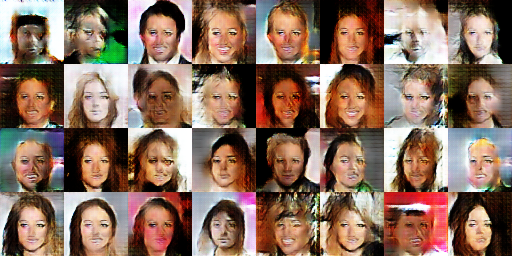

In [16]:
rng = MersenneTwister(1)
fakes = netG(randn(rng, Float32, 1, 1, nz, 32) |> gpu) |> cpu;
show_imgs(fakes, 8)